# preprocess

In [1]:
!pip install kagglehub

In [2]:
import tensorflow as tf
import kagglehub

path = kagglehub.dataset_download(
    "brendanartley/cartoon-faces-googles-cartoon-set"
)
dataset_path = path + '/cartoonset100k_jpg/'

# 參數設定
IMG_HEIGHT = 96
IMG_WIDTH = 96
BATCH_SIZE = 64
LATENT_DIM = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    label_mode=None,
    color_mode='rgb',
    image_size=(IMG_HEIGHT, IMG_WIDTH),  #resize
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)

train_ds = train_ds.map(
    tf.keras.layers.Rescaling(1./255),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Using Colab cache for faster access to the 'cartoon-faces-googles-cartoon-set' dataset.
Found 100000 files.


# build


In [3]:
from tensorflow.keras import layers, models, backend as K
import tensorflow as tf


# 取樣層
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


encoder_inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

#Encoder
x = layers.Conv2D(64, 3, strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(512, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

shape_before_flatten = K.int_shape(x)[1:]
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)

z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

#Decoder
latent_inputs = layers.Input(shape=(LATENT_DIM,))

x = layers.Dense(shape_before_flatten[0] * shape_before_flatten[1] * shape_before_flatten[2], activation="relu")(latent_inputs)
x = layers.Reshape(shape_before_flatten)(x)

x = layers.Conv2DTranspose(512, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)


decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")

In [4]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]


    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction


    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            #重建loss
            reconstruction_loss = tf.reduce_sum(
              tf.keras.losses.binary_crossentropy(data, reconstruction),
              axis=(1, 2)
            )
            #KL loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_sum(kl_loss, axis=1)

            beta = 0.5
            total_loss = tf.reduce_mean(reconstruction_loss + beta * kl_loss)



        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



#training

In [5]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

In [6]:
# vae.build((BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3))
# vae.load_weights('vae_cartoon_faces_v3.keras')

In [7]:
history = vae.fit(train_ds, epochs=10)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 409s 242ms/step - kl_loss: 97.7073 - loss: 1834.4233 - reconstruction_loss: 1785.5698
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 217s 139ms/step - kl_loss: 55.2706 - loss: 1231.7584 - reconstruction_loss: 1204.1238
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 216s 138ms/step - kl_loss: 45.0147 - loss: 1191.5972 - reconstruction_loss: 1169.0892
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 215s 138ms/step - kl_loss: 41.6619 - loss: 1168.4974 - reconstruction_loss: 1147.6669
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 215s 137ms/step - kl_loss: 40.2940 - loss: 1155.8716 - reconstruction_loss: 1135.7244
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 214s 137ms/step - kl_loss: 39.2312 - loss: 1149.4340 - reconstruction_loss: 1129.8190
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 214s 137ms/step - kl_loss: 38.6893 - loss: 1145.4885 - reconstruction_loss: 1126.1437
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 213s 136ms/step - kl_loss: 38.1915 - loss: 1142.8132 - reconst

In [ ]:
#vae.save('vae_cartoon_faces_v5.keras')

# result


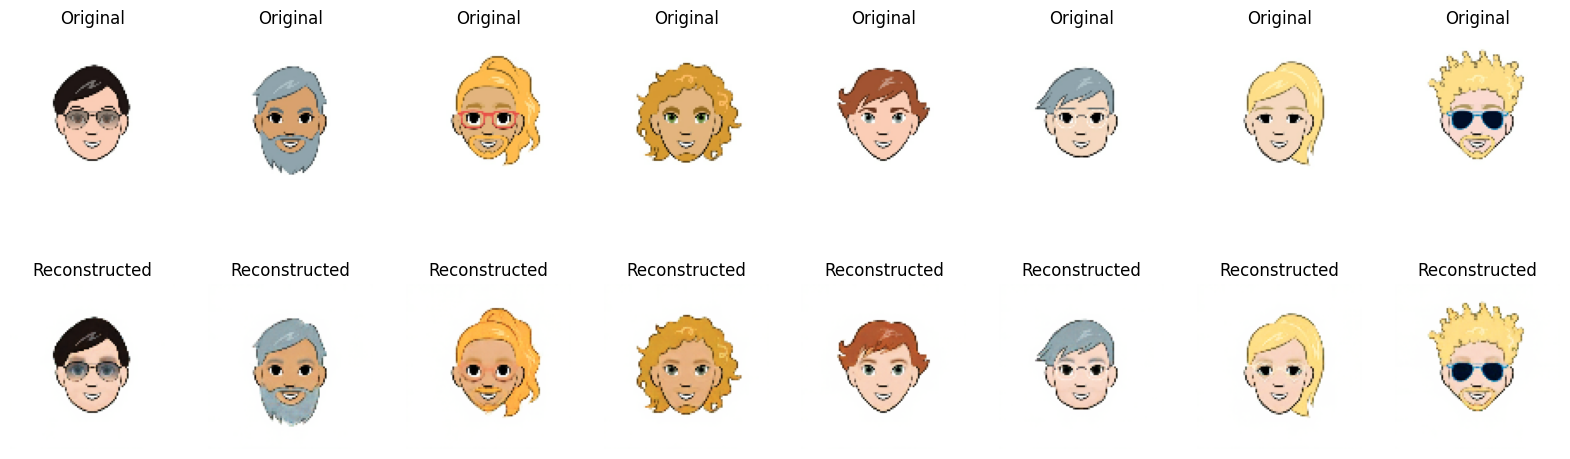

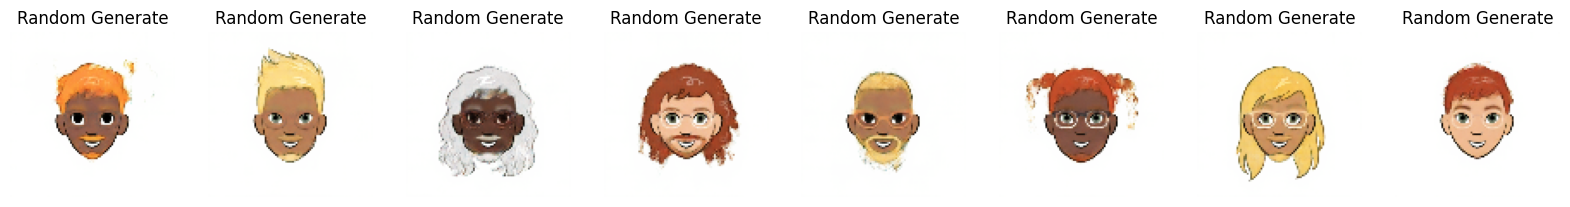

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(vae, data, n=8):

    images = next(iter(data))[:n]
    encoded_imgs = vae.encoder(images)
    z_mean, z_log_var, z = encoded_imgs
    decoded_imgs = vae.decoder(z)

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # 原圖
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].numpy())
        plt.title("Original")
        plt.axis("off")

        # 重建圖
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].numpy())
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

    # 生成測試
    random_latent_vectors = tf.random.normal(shape=(n, LATENT_DIM))
    generated_images = vae.decoder(random_latent_vectors)

    plt.figure(figsize=(20, 3))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.title("Random Generate")
        plt.imshow(generated_images[i].numpy())
        plt.axis("off")
    plt.show()


plot_results(vae, train_ds)

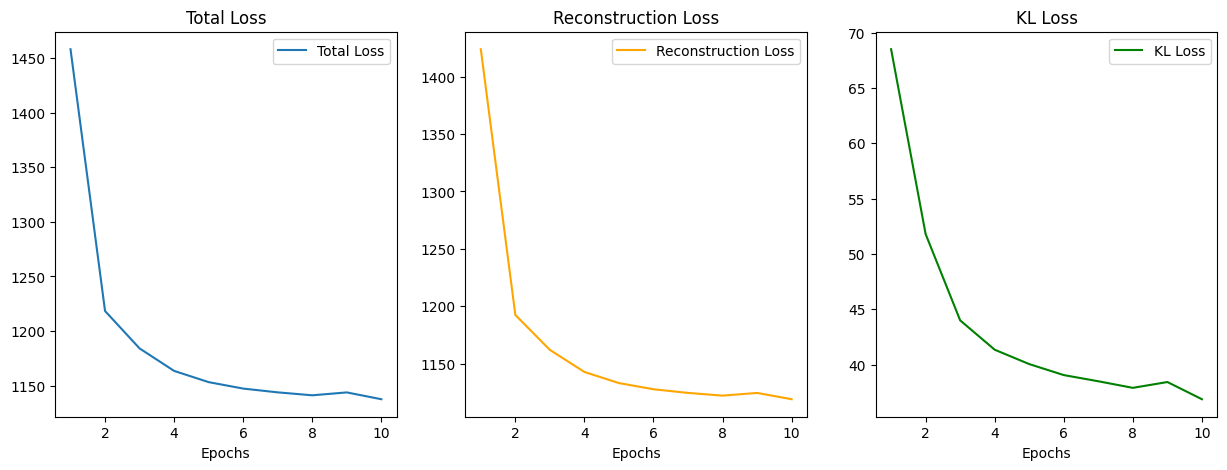

In [9]:
import matplotlib.pyplot as plt

loss = history.history['loss']
reconstruction_loss = history.history['reconstruction_loss']
kl_loss = history.history['kl_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, loss, label='Total Loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, reconstruction_loss, label='Reconstruction Loss', color='orange')
plt.title('Reconstruction Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, kl_loss, label='KL Loss', color='green')
plt.title('KL Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

# result - reconstruction


In [10]:
def plot_reconstruction(vae, data, n=8):

    images = next(iter(data))[:n]

    encoded_imgs = vae.encoder(images)
    z_mean, z_log_var, z = encoded_imgs
    decoded_imgs = vae.decoder(z)

    plt.figure(figsize=(20, 5))
    for i in range(n):

        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].numpy())
        plt.title("Original")
        plt.axis("off")

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].numpy())
        plt.title("Reconstructed")
        plt.axis("off")

    plt.suptitle("Reconstruction Check (Input vs Output)", fontsize=16)
    plt.show()

def plot_interpolation(vae, data, steps=10):

    images = next(iter(data))[:2]
    image_a = images[0:1]
    image_b = images[1:2]

    z_a, _, _ = vae.encoder(image_a)
    z_b, _, _ = vae.encoder(image_b)


    alphas = np.linspace(0, 1, steps)
    z_interpolated = np.array([z_a * (1 - alpha) + z_b * alpha for alpha in alphas])
    z_interpolated = z_interpolated.reshape(steps, -1)

    decoded_imgs = vae.decoder(z_interpolated)


    plt.figure(figsize=(20, 3))
    for i in range(steps):
        ax = plt.subplot(1, steps, i + 1)
        plt.imshow(decoded_imgs[i].numpy())
        plt.axis("off")
        if i == 0:
            plt.title("Start (A)")
        elif i == steps - 1:
            plt.title("End (B)")

    plt.suptitle("Latent Space Interpolation", fontsize=16)
    plt.show()


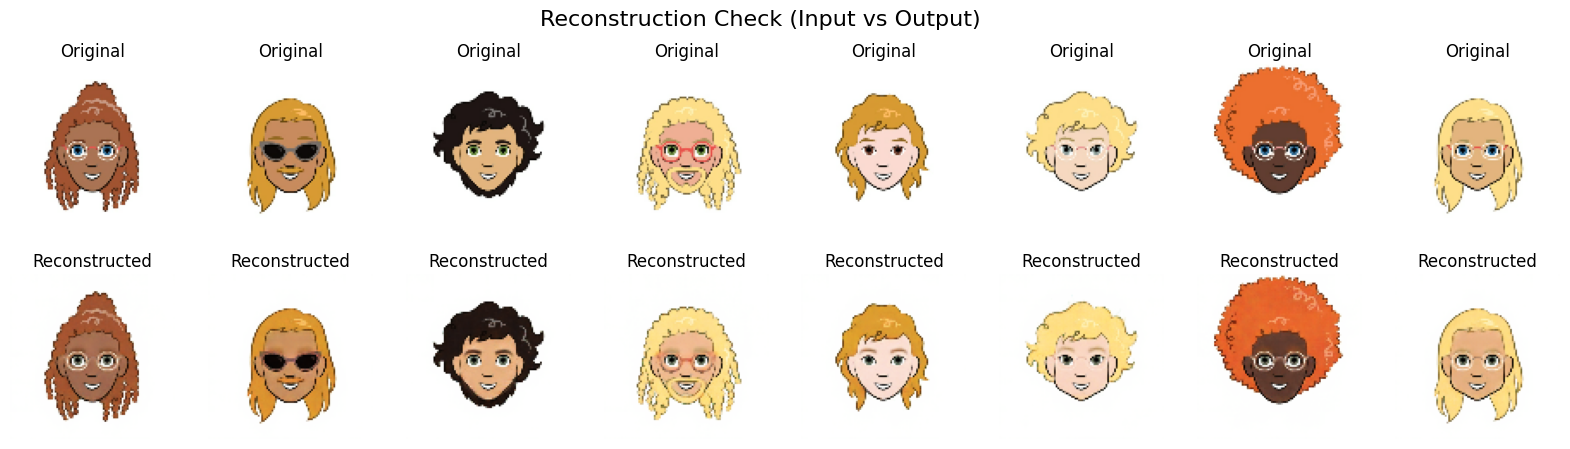

In [11]:
plot_reconstruction(vae, train_ds)

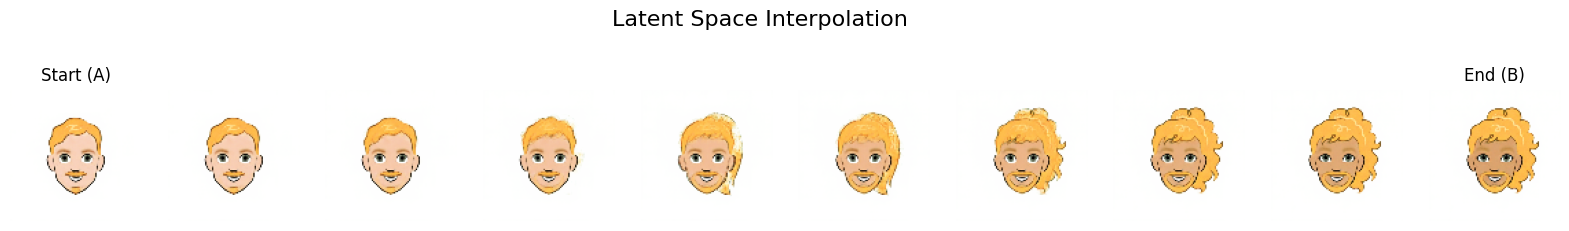

In [12]:
plot_interpolation(vae, train_ds)

# result - latent generate

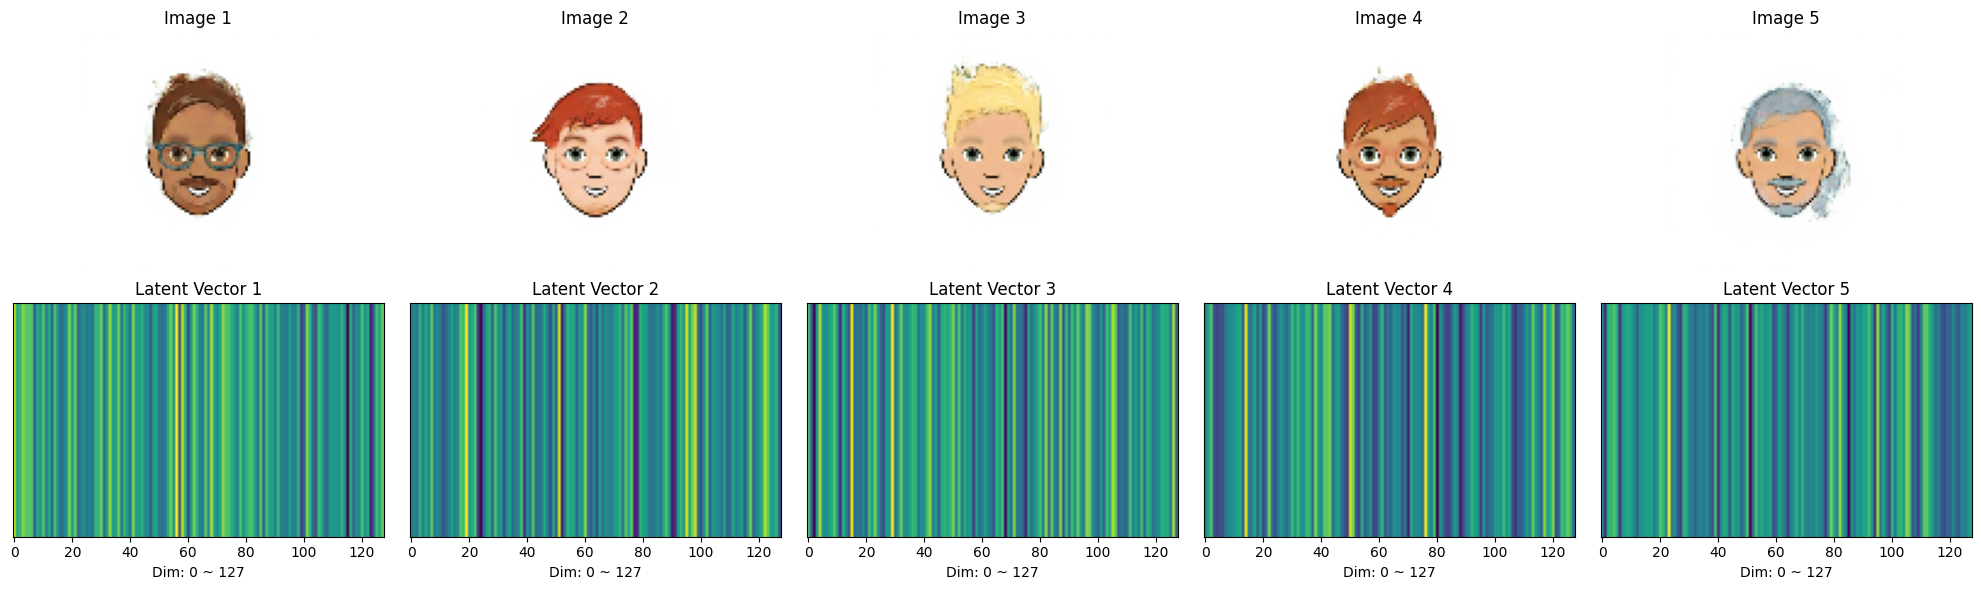

In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def generate_with_latent_analysis(vae, n=5, latent_dim=128):

    z = tf.random.normal(shape=(n, latent_dim))
    generated_images = vae.decoder(z)
    plt.figure(figsize=(20, 6))

    for i in range(n):

        ax = plt.subplot(2, n, i + 1)
        plt.imshow(generated_images[i].numpy())
        plt.title(f"Image {i+1}")
        plt.axis("off")


        ax = plt.subplot(2, n, i + 1 + n)
        vector_visualization = z[i].numpy().reshape(1, -1)

        plt.imshow(vector_visualization, aspect='auto', cmap='viridis')
        plt.title(f"Latent Vector {i+1}")

        plt.yticks([])
        plt.xlabel("Dim: 0 ~ 127")

    plt.tight_layout()
    plt.show()

    return z.numpy()

latent_vectors = generate_with_latent_analysis(vae, n=5, latent_dim=LATENT_DIM)

In [14]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_curve(vae, data, n_samples=3000):

    images = []
    for batch in data:
        images.append(batch)
        if len(images) * batch.shape[0] >= n_samples:
            break
    x_test = np.concatenate(images, axis=0)[:n_samples]
    z_mean, _, _ = vae.encoder.predict(x_test, verbose=0)

    pca = PCA()
    pca.fit(z_mean)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.figure(figsize=(10, 5))

    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, linewidth=2)

    plt.title("PCA Cumulative Variance")
    plt.xlabel("Number of PCs")
    plt.ylabel("Explained Variance (0.0 ~ 1.0)")
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.05)

    print(f"前 15 個 PC 累積了解釋度: {cumulative_variance[14]:.2%}")

    return pca, z_mean

def analyze_pca_2d(vae, pca, z_mean, grid_size=15):

    ratios = pca.explained_variance_ratio_

    print(f"PC 1 解釋變異量: {ratios[0]:.2%}")
    print(f"PC 2 解釋變異量: {ratios[1]:.2%}")
    print(f"兩者合計 (PC1 + PC2): {ratios[0] + ratios[1]:.2%}")

    scale = 2.0

    grid_x = np.linspace(-scale, scale, grid_size)
    grid_y = np.linspace(-scale, scale, grid_size)

    z_center = np.mean(z_mean, axis=0)
    pc1_vec = pca.components_[0]
    pc2_vec = pca.components_[1]
    std_devs = np.sqrt(pca.explained_variance_)

    img_h, img_w = 96, 96
    figure = np.zeros((img_h * grid_size, img_w * grid_size, 3))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):

            z_sample = z_center + (xi * std_devs[0] * pc1_vec) + (yi * std_devs[1] * pc2_vec)
            z_sample = np.expand_dims(z_sample, axis=0)
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(img_h, img_w, 3)
            figure[i * img_h : (i + 1) * img_h,j * img_w : (j + 1) * img_w] = digit

    plt.figure(figsize=(15, 15))
    plt.imshow(figure)
    plt.title("2D Face Map (PC1 vs PC2)", fontsize=20)
    plt.xlabel(f"PC 1 (Variance: {ratios[0]:.2%}) ")
    plt.ylabel(f"PC 2 (Variance: {ratios[1]:.2%}) ")

    plt.xticks([])
    plt.yticks([])


前 15 個 PC 累積了解釋度: 88.51%


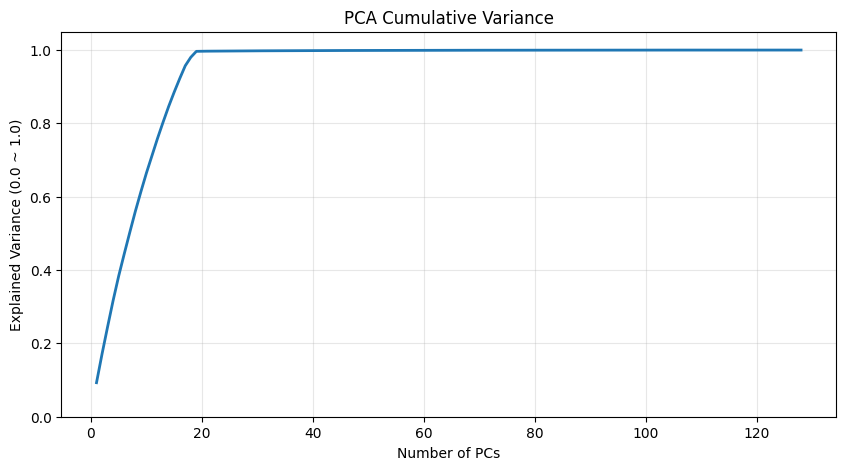

In [15]:
pca_full, z_mean_data = plot_cumulative_curve(vae, train_ds)

PC 1 解釋變異量: 9.28%
PC 2 解釋變異量: 7.85%
兩者合計 (PC1 + PC2): 17.13%


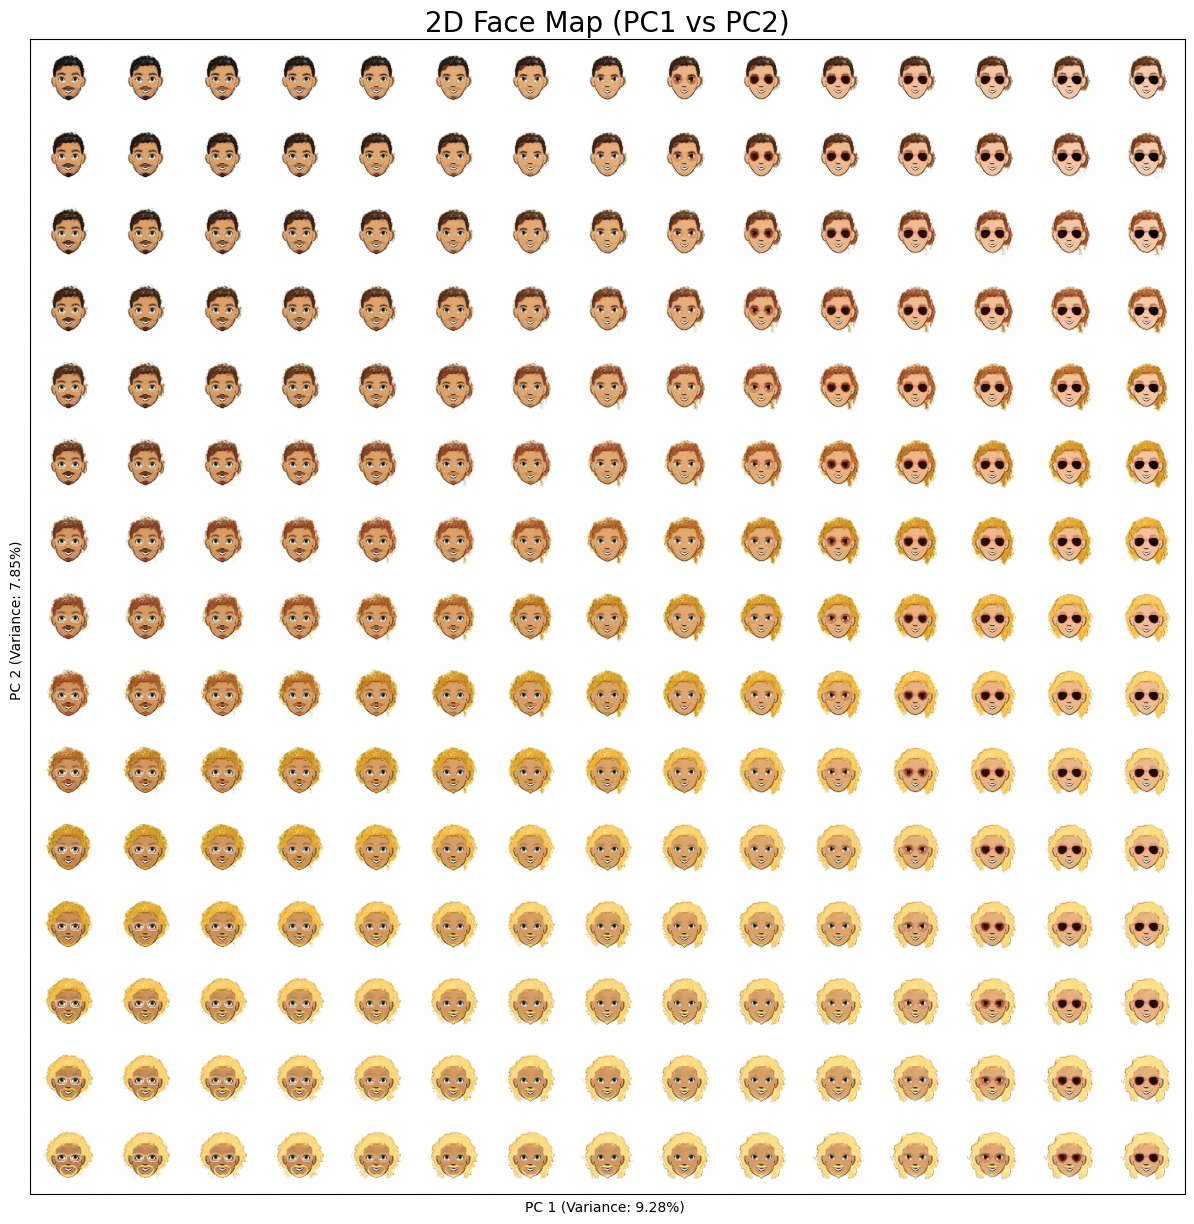

In [16]:
analyze_pca_2d(vae, pca_full, z_mean_data)

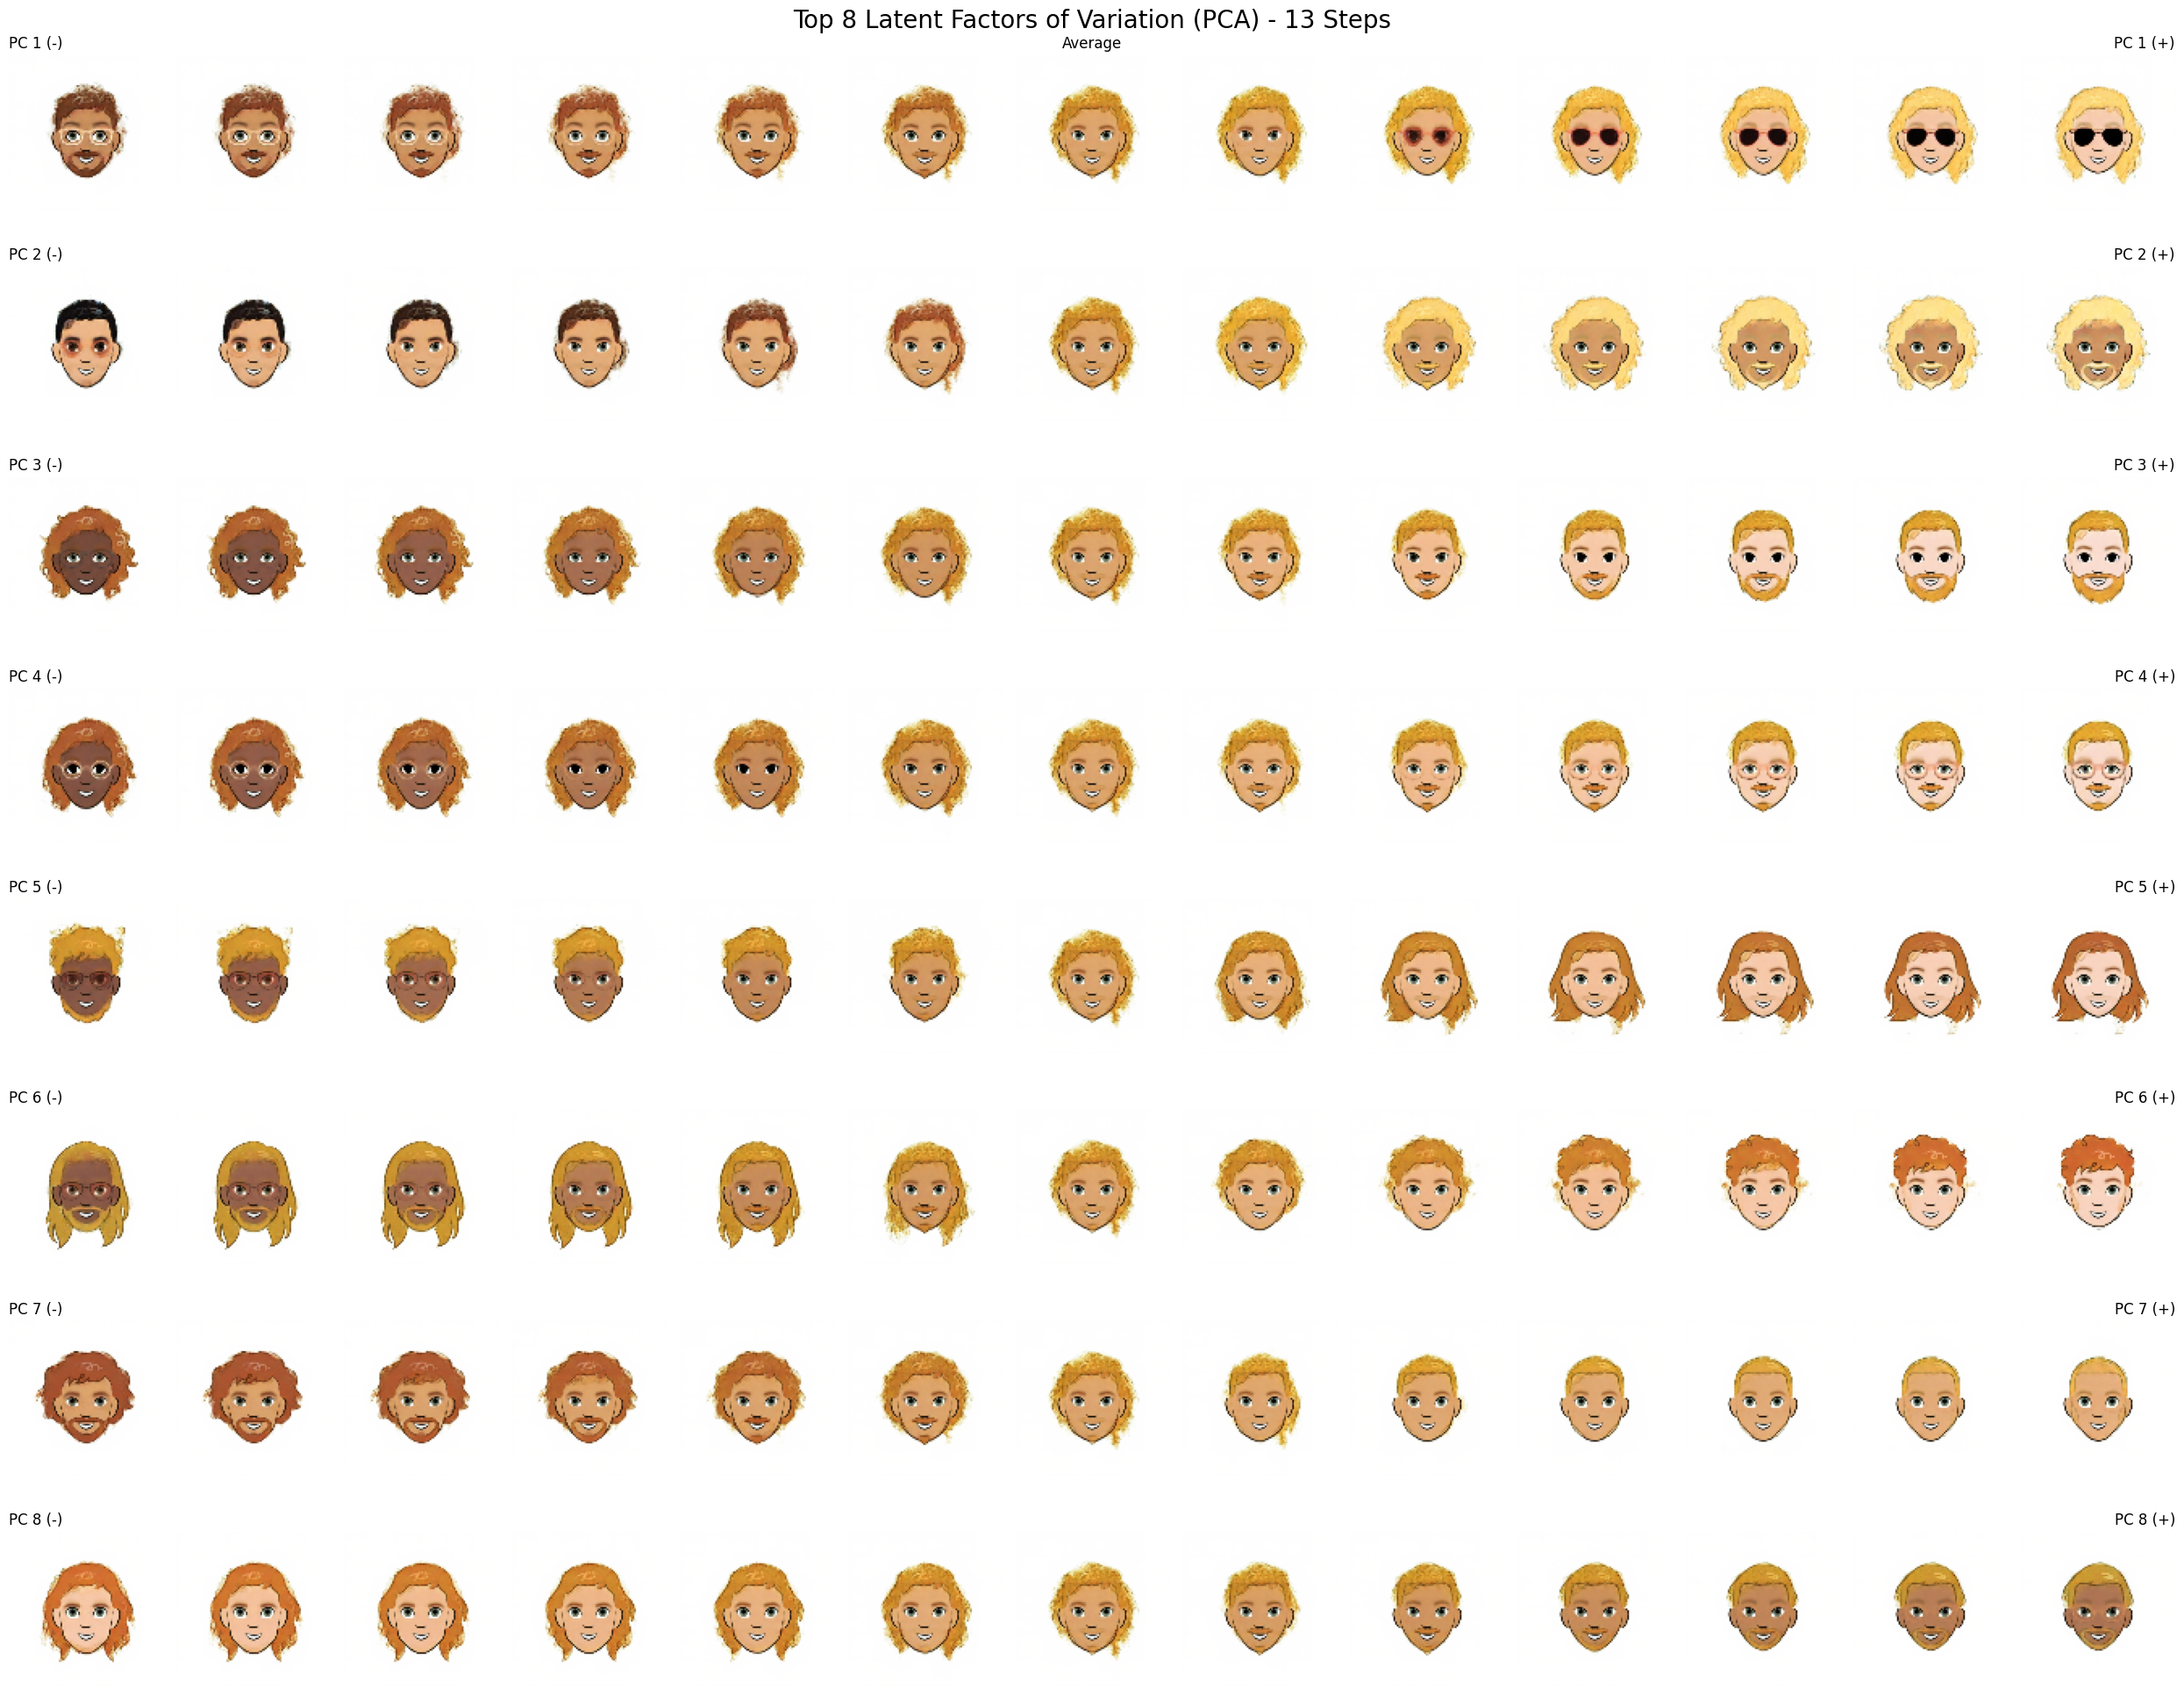

In [17]:
def analyze_pca(vae, pca, z_mean, n_components=8):

    z_center = np.mean(z_mean, axis=0)
    std_devs = np.sqrt(pca.explained_variance_)[:n_components]
    grid_steps = 13
    factors = np.linspace(-3, 3, grid_steps)

    plt.figure(figsize=(25, 2.5 * n_components))

    for i in range(n_components):
        component_vector = pca.components_[i]
        std = std_devs[i]

        z_line = []
        for f in factors:
            z_new = z_center + (f * std * component_vector)
            z_line.append(z_new)

        z_line = np.array(z_line)
        decoded_imgs = vae.decoder(z_line)

        for j in range(grid_steps):
            ax = plt.subplot(n_components, grid_steps, i * grid_steps + j + 1)

            plt.imshow(decoded_imgs[j].numpy())
            plt.axis("off")

            if j == 0:
                ax.set_title(f"PC {i+1} (-)", loc='left', fontsize=12)
            if j == grid_steps // 2:
                if i == 0: ax.set_title("Average", fontsize=12)
            if j == grid_steps - 1:
                ax.set_title(f"PC {i+1} (+)", loc='right', fontsize=12)

    plt.suptitle(f"Top {n_components} Latent Factors of Variation (PCA) - {grid_steps} Steps", fontsize=20)
    plt.tight_layout()
    plt.show()

analyze_pca(vae, pca_full, z_mean_data, n_components=8)